
# Consumption Prediction Model

Modelo para estimar `Quantity_Consumed` por vuelo y producto usando el dataset de Consumption Prediction.


## 1. Configuracion y carga de datos

In [1]:

from __future__ import annotations

import warnings
from pathlib import Path

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    mean_absolute_percentage_error,
    mean_absolute_error,
    r2_score,
)
from sklearn.model_selection import GroupKFold, GroupShuffleSplit, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from IPython.display import display

warnings.filterwarnings('ignore')

sns.set_theme(style='whitegrid', palette='deep')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

RANDOM_STATE = 42

possible_paths = [
    Path('../data/external/consumption_prediction.xlsx'),
    Path('../data/consumption_prediction.xlsx'),
    Path('data/external/consumption_prediction.xlsx'),
    Path('data/consumption_prediction.xlsx'),
    Path('Gategroup 2025-20251025T180038Z-1-001/Gategroup 2025/HackMTY2025_ChallengeDimensions/02_ConsumptionPrediction/[HackMTY2025]_ConsumptionPrediction_Dataset_v1.xlsx'),
    Path('../Gategroup 2025-20251025T180038Z-1-001/Gategroup 2025/HackMTY2025_ChallengeDimensions/02_ConsumptionPrediction/[HackMTY2025]_ConsumptionPrediction_Dataset_v1.xlsx')
]

for candidate in possible_paths:
    if candidate.exists():
        DATA_PATH = candidate
        break
else:
    raise FileNotFoundError('No se encontro el dataset de consumption prediction en las rutas esperadas.')

print(f'Usando dataset: {DATA_PATH}')

df = pd.read_excel(DATA_PATH)
print(f"Registros: {len(df)}, Columnas: {df.shape[1]}")
df.head()


Usando dataset: ..\data\external\consumption_prediction.xlsx


Registros: 792, Columnas: 13


,Flight_ID,Origin,Date,Flight_Type,Service_Type,Passenger_Count,Product_ID,Product_Name,Standard_Specification_Qty,Quantity_Returned,Quantity_Consumed,Unit_Cost,Crew_Feedback
0,AM109,DOH,2025-09-26,medium-haul,Retail,272,BRD001,Bread Roll Pack,62,7,55,0.35,NaN
1,AM109,DOH,2025-09-26,medium-haul,Retail,272,CRK075,Butter Cookies 75g,74,14,60,0.75,NaN
2,AM109,DOH,2025-09-26,medium-haul,Retail,272,DRK023,Sparkling Water 330ml,125,30,95,0.45,NaN
3,AM109,DOH,2025-09-26,medium-haul,Retail,272,DRK024,Still Water 500ml,110,19,91,0.50,NaN
4,LX110,DOH,2025-09-26,medium-haul,Pick & Pack,272,BRD001,Bread Roll Pack,177,58,119,0.35,NaN


## 2. Enriquecimiento de datos externos

In [2]:

expiration_paths = [
    Path('../data/external/expiration_management.xlsx'),
    Path('../data/expiration_management.xlsx'),
    Path('data/external/expiration_management.xlsx'),
    Path('data/expiration_management.xlsx'),
    Path('Gategroup 2025-20251025T180038Z-1-001/Gategroup 2025/HackMTY2025_ChallengeDimensions/01_ExpirationDateManagement/[HackMTY2025]_ExpirationDateManagement_Dataset_v1.xlsx'),
    Path('../Gategroup 2025-20251025T180038Z-1-001/Gategroup 2025/HackMTY2025_ChallengeDimensions/01_ExpirationDateManagement/[HackMTY2025]_ExpirationDateManagement_Dataset_v1.xlsx')
]

for candidate in expiration_paths:
    if candidate.exists():
        EXPIRATION_PATH = candidate
        break
else:
    raise FileNotFoundError('No se encontro el dataset de expiracion en las rutas esperadas.')

expiration_df = pd.read_excel(EXPIRATION_PATH)
import re

def parse_weight(value: object) -> float:
    if pd.isna(value):
        return np.nan
    text = str(value).strip().lower()
    match = re.search(r'([0-9]+(?:\.[0-9]+)?)', text)
    if not match:
        return np.nan
    weight = float(match.group(1))
    if 'kg' in text:
        weight *= 1000.0
    elif 'l' in text and 'ml' not in text:
        weight *= 1000.0
    return weight

expiration_df['Weight_or_Volume'] = expiration_df['Weight_or_Volume'].apply(parse_weight)

product_catalog = (
    expiration_df.groupby(['Product_ID', 'Product_Name'])['Weight_or_Volume']
    .mean()
    .reset_index()
    .rename(columns={'Weight_or_Volume': 'product_weight'})
)

product_count = product_catalog['Product_ID'].nunique()
print(f'Catalogo de peso disponible para {product_count} productos.')

productivity_paths = [
    Path('../data/external/productivity_estimation.xlsx'),
    Path('../data/productivity_estimation.xlsx'),
    Path('data/external/productivity_estimation.xlsx'),
    Path('data/productivity_estimation.xlsx'),
    Path('Gategroup 2025-20251025T180038Z-1-001/Gategroup 2025/HackMTY2025_ChallengeDimensions/03_ProductivityEstimation/[HackMTY2025]_ProductivityEstimation_Dataset_v1.xlsx'),
    Path('../Gategroup 2025-20251025T180038Z-1-001/Gategroup 2025/HackMTY2025_ChallengeDimensions/03_ProductivityEstimation/[HackMTY2025]_ProductivityEstimation_Dataset_v1.xlsx')
]

for candidate in productivity_paths:
    if candidate.exists():
        PRODUCTIVITY_PATH = candidate
        break
else:
    raise FileNotFoundError('No se encontro el dataset de productividad en las rutas esperadas.')

productivity_df = pd.read_excel(PRODUCTIVITY_PATH)
for column in ['Total_Items', 'Unique_Item_Types']:
    if column in productivity_df.columns:
        productivity_df[column] = pd.to_numeric(productivity_df[column], errors='coerce')
productivity_df['Item_List'] = productivity_df.get('Item_List', pd.Series(dtype=str)).astype(str)

flight_complexity = (
    productivity_df.groupby('Flight_Type', as_index=False)
    .agg({
        'Total_Items': 'mean',
        'Unique_Item_Types': 'mean'
    })
    .rename(columns={
        'Total_Items': 'flight_avg_total_items',
        'Unique_Item_Types': 'flight_avg_unique_items'
    })
)

print('Resumen de complejidad por tipo de vuelo:')
print(flight_complexity)


Catalogo de peso disponible para 10 productos.
Resumen de complejidad por tipo de vuelo:
  Flight_Type  flight_avg_total_items  flight_avg_unique_items
0    Business               24.250000                 9.596154
1     Economy               24.604167                 9.791667


## 3. Limpieza basica y exploracion

In [3]:

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Flight_ID', 'Product_ID', 'Date']).reset_index(drop=True)

if 'Crew_Feedback' in df.columns:
    feedback_null_ratio = df['Crew_Feedback'].isna().mean()
    print(f"Crew_Feedback NaNs: {feedback_null_ratio:.2%}")
    if feedback_null_ratio > 0.9:
        df = df.drop(columns=['Crew_Feedback'])

print('Informacion del dataframe:')
df.info()

print('Estadisticas de consumo:')
print(df['Quantity_Consumed'].describe())

print('Consumo promedio por producto (Top 10):')
product_summary = (
    df.groupby(['Product_ID', 'Product_Name'])['Quantity_Consumed']
      .agg(['count', 'mean', 'sum'])
      .sort_values('sum', ascending=False)
)
product_summary.head(10)


Crew_Feedback NaNs: 91.29%
Informacion del dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 792 entries, 0 to 791
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Flight_ID                   792 non-null    object        
 1   Origin                      792 non-null    object        
 2   Date                        792 non-null    datetime64[ns]
 3   Flight_Type                 792 non-null    object        
 4   Service_Type                792 non-null    object        
 5   Passenger_Count             792 non-null    int64         
 6   Product_ID                  792 non-null    object        
 7   Product_Name                792 non-null    object        
 8   Standard_Specification_Qty  792 non-null    int64         
 9   Quantity_Returned           792 non-null    int64         
 10  Quantity_Consumed           792 non-null    int64         
 11  Unit

,,count,mean,sum
Product_ID,Product_Name,,,
JCE200,Juice 200ml,82,115.987805,9511
DRK024,Still Water 500ml,76,124.618421,9471
DRK023,Sparkling Water 330ml,77,115.571429,8899
SNK001,Snack Box Economy,83,85.277108,7078
CRK075,Butter Cookies 75g,85,81.576471,6934
BRD001,Bread Roll Pack,77,88.025974,6778
COF200,Instant Coffee Stick,79,80.405063,6352
HTB110,Herbal Tea Bag,79,79.645570,6292
CHO050,Chocolate Bar 50g,81,75.703704,6132


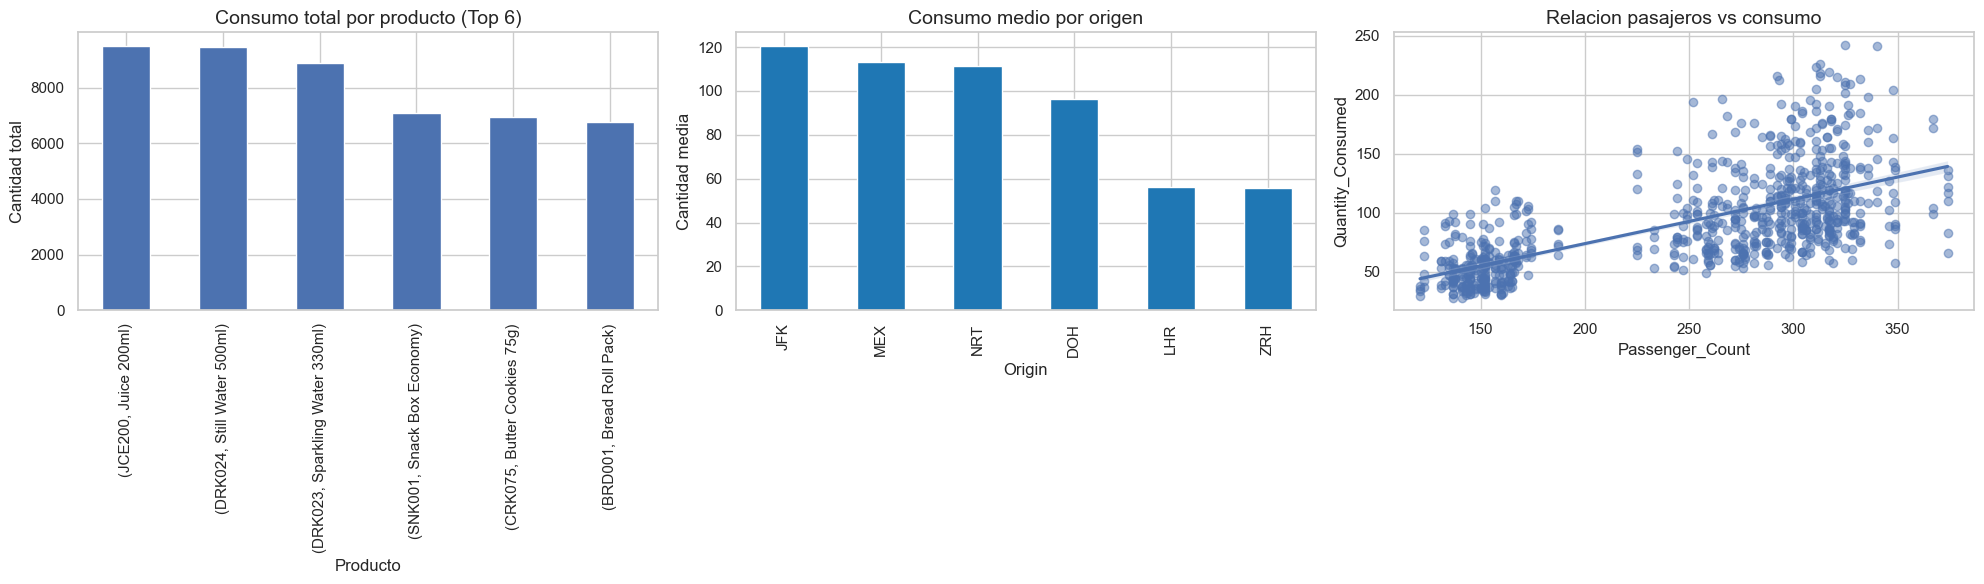

Correlacion Passenger_Count vs Quantity_Consumed: 0.653


In [4]:

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

product_summary.head(6).plot(
    kind='bar', y='sum', ax=axes[0], legend=False,
    title='Consumo total por producto (Top 6)'
)
axes[0].set_ylabel('Cantidad total')
axes[0].set_xlabel('Producto')

origin_summary = df.groupby('Origin')['Quantity_Consumed'].mean().sort_values(ascending=False)
origin_summary.plot(kind='bar', ax=axes[1], title='Consumo medio por origen', color='#1f77b4')
axes[1].set_ylabel('Cantidad media')

sns.regplot(
    data=df,
    x='Passenger_Count',
    y='Quantity_Consumed',
    ax=axes[2],
    scatter_kws={'alpha': 0.5}
)
axes[2].set_title('Relacion pasajeros vs consumo')
plt.tight_layout()
plt.show()

corr = df[['Passenger_Count', 'Quantity_Consumed']].corr().iloc[0, 1]
print(f'Correlacion Passenger_Count vs Quantity_Consumed: {corr:.3f}')


## 4. Ingenieria de variables

In [5]:

feature_df = df.copy()

numeric_columns = [
    'Passenger_Count',
    'Standard_Specification_Qty',
    'Quantity_Returned',
    'Quantity_Consumed',
    'Unit_Cost'
]
for column in numeric_columns:
    if column in feature_df.columns:
        feature_df[column] = pd.to_numeric(feature_df[column], errors='coerce')

feature_df['dayofweek'] = feature_df['Date'].dt.dayofweek
feature_df['month'] = feature_df['Date'].dt.month
feature_df['weekofyear'] = feature_df['Date'].dt.isocalendar().week.astype(int)
feature_df['dayofyear'] = feature_df['Date'].dt.dayofyear
feature_df['is_weekend'] = (feature_df['dayofweek'] >= 5).astype(int)

passenger_for_ratios = feature_df['Passenger_Count'].replace(0, np.nan)
spec_for_ratios = feature_df['Standard_Specification_Qty'].replace(0, np.nan)

feature_df['spec_per_passenger'] = (
    spec_for_ratios / passenger_for_ratios
).replace([np.inf, -np.inf], np.nan)
feature_df['spec_per_passenger'] = feature_df['spec_per_passenger'].fillna(
    feature_df['spec_per_passenger'].median()
)

weight_median = product_catalog['product_weight'].median()
feature_df = feature_df.merge(product_catalog[['Product_ID', 'product_weight']], on='Product_ID', how='left')
feature_df['product_weight'] = feature_df['product_weight'].fillna(weight_median)

feature_df = feature_df.merge(flight_complexity, on='Flight_Type', how='left')
for col, fallback in [('flight_avg_total_items', flight_complexity['flight_avg_total_items'].mean()),
                      ('flight_avg_unique_items', flight_complexity['flight_avg_unique_items'].mean())]:
    feature_df[col] = feature_df[col].fillna(fallback)

feature_df['consumption_per_passenger'] = (
    feature_df['Quantity_Consumed'] / passenger_for_ratios
).replace([np.inf, -np.inf], np.nan)
feature_df['return_ratio'] = (
    feature_df['Quantity_Returned'] / spec_for_ratios
).replace([np.inf, -np.inf], np.nan)
feature_df['consumed_ratio'] = (
    feature_df['Quantity_Consumed'] / spec_for_ratios
).replace([np.inf, -np.inf], np.nan)

feature_df['weight_per_passenger'] = feature_df['product_weight'] * feature_df['consumption_per_passenger']
feature_df['weight_per_spec'] = feature_df['product_weight'] * feature_df['Standard_Specification_Qty']

ratio_columns = ['consumption_per_passenger', 'return_ratio', 'consumed_ratio', 'weight_per_passenger']
for col in ratio_columns:
    feature_df[col] = feature_df[col].fillna(feature_df[col].median())

TARGET = 'Quantity_Consumed'
GROUPS = feature_df['Flight_ID']

categorical_features = ['Origin', 'Flight_Type', 'Service_Type', 'Product_ID', 'Product_Name']
numeric_features = [
    'Passenger_Count',
    'Standard_Specification_Qty',
    'Unit_Cost',
    'spec_per_passenger',
    'dayofweek',
    'month',
    'weekofyear',
    'dayofyear',
    'is_weekend',
    'product_weight',
    'flight_avg_total_items',
    'flight_avg_unique_items',
    'consumption_per_passenger',
    'return_ratio',
    'consumed_ratio',
    'weight_per_passenger',
    'weight_per_spec'
]

FEATURES = categorical_features + numeric_features

missing_cols = [col for col in FEATURES if feature_df[col].isna().any()]
if missing_cols:
    print('Columnas con NaN y su estrategia de imputacion:')
    for col in missing_cols:
        if col in numeric_features:
            fill_value = feature_df[col].median()
            feature_df[col] = feature_df[col].fillna(fill_value)
            print(f'- {col}: imputado con mediana ({fill_value:.2f})')
        else:
            fill_value = feature_df[col].mode()[0]
            feature_df[col] = feature_df[col].fillna(fill_value)
            print(f'- {col}: imputado con moda ({fill_value})')

X = feature_df[FEATURES]
y = feature_df[TARGET]
print(f'Caracteristicas seleccionadas: {len(FEATURES)}')
X.head()


Caracteristicas seleccionadas: 22


,Origin,Flight_Type,Service_Type,Product_ID,Product_Name,Passenger_Count,Standard_Specification_Qty,Unit_Cost,spec_per_passenger,dayofweek,...,dayofyear,is_weekend,product_weight,flight_avg_total_items,flight_avg_unique_items,consumption_per_passenger,return_ratio,consumed_ratio,weight_per_passenger,weight_per_spec
0,JFK,long-haul,Retail,BRD001,Bread Roll Pack,288,67,0.35,0.232639,4,...,269,0,201.641414,24.427083,9.69391,0.194444,0.164179,0.835821,39.208053,13509.974747
1,JFK,long-haul,Retail,CHO050,Chocolate Bar 50g,288,79,0.80,0.274306,4,...,269,0,201.641414,24.427083,9.69391,0.225694,0.177215,0.822785,45.509347,15929.671717
2,JFK,long-haul,Retail,CRK075,Butter Cookies 75g,288,80,0.75,0.277778,4,...,269,0,201.641414,24.427083,9.69391,0.222222,0.200000,0.800000,44.809203,16131.313131
3,JFK,long-haul,Retail,HTB110,Herbal Tea Bag,288,89,0.06,0.309028,4,...,269,0,201.641414,24.427083,9.69391,0.291667,0.056180,0.943820,58.812079,17946.085859
4,JFK,long-haul,Retail,JCE200,Juice 200ml,288,114,0.55,0.395833,4,...,269,0,201.641414,24.427083,9.69391,0.322917,0.184211,0.815789,65.113373,22987.121212


## 5. Division de datos (por vuelo)

In [6]:

splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)
train_idx, test_idx = next(splitter.split(X, y, groups=GROUPS))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
train_groups = GROUPS.iloc[train_idx]

print(f'Train size: {len(X_train)}, Test size: {len(X_test)}')
print(f'Flights en train: {train_groups.nunique()}, Flights en test: {GROUPS.iloc[test_idx].nunique()}')


Train size: 625, Test size: 167
Flights en train: 115, Flights en test: 29


## 6. Pipeline de modelado y busqueda de hiperparametros

In [7]:

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('numeric', 'passthrough', numeric_features),
    ]
)

xgb_regressor = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=400,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=3,
    gamma=0,
    random_state=RANDOM_STATE,
    tree_method='hist'
)

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', xgb_regressor)
    ]
)

param_distributions = {
    'regressor__n_estimators': [300, 500, 700, 900],
    'regressor__learning_rate': [0.03, 0.05, 0.08, 0.1],
    'regressor__max_depth': [3, 4, 5, 6],
    'regressor__subsample': [0.7, 0.85, 1.0],
    'regressor__colsample_bytree': [0.7, 0.85, 1.0],
    'regressor__min_child_weight': [1, 3, 5],
    'regressor__gamma': [0, 0.1, 0.2]
}

group_kfold = GroupKFold(n_splits=5)

search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=15,
    scoring='neg_mean_absolute_percentage_error',
    cv=group_kfold,
    random_state=RANDOM_STATE,
    verbose=1,
    n_jobs=1
)

search.fit(X_train, y_train, groups=train_groups)

best_pipeline = search.best_estimator_
print('Mejores hiperparametros:')
print(search.best_params_)


Fitting 5 folds for each of 15 candidates, totalling 75 fits


Mejores hiperparametros:
{'regressor__subsample': 0.7, 'regressor__n_estimators': 900, 'regressor__min_child_weight': 3, 'regressor__max_depth': 6, 'regressor__learning_rate': 0.03, 'regressor__gamma': 0.1, 'regressor__colsample_bytree': 0.85}


## 7. Evaluacion del modelo

In [8]:

y_pred_train = best_pipeline.predict(X_train)
y_pred_test = best_pipeline.predict(X_test)

train_mape = mean_absolute_percentage_error(y_train, y_pred_train)
test_mape = mean_absolute_percentage_error(y_test, y_pred_test)
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print(f'Train MAPE: {train_mape * 100:.2f}%')
print(f'Test  MAPE: {test_mape * 100:.2f}%')
print(f'Train MAE : {train_mae:.2f}')
print(f'Test  MAE : {test_mae:.2f}')
print(f'Test  R^2 : {test_r2:.3f}')

results_df = pd.DataFrame({
    'Quantity_Consumed': y_test,
    'Predicted': y_pred_test,
    'Passenger_Count': X_test['Passenger_Count'],
    'Origin': X_test['Origin'],
    'Flight_Type': X_test['Flight_Type'],
    'Service_Type': X_test['Service_Type'],
    'Product_ID': X_test['Product_ID'],
    'Product_Weight': X_test['product_weight'],
    'Consumption_per_Passenger': X_test['consumption_per_passenger'],
    'Flight_Avg_Total_Items': X_test['flight_avg_total_items']
}).reset_index(drop=True)

results_df.head(10)


Train MAPE: 0.20%
Test  MAPE: 1.62%
Train MAE : 0.15
Test  MAE : 1.33
Test  R^2 : 0.997


,Quantity_Consumed,Predicted,Passenger_Count,Origin,Flight_Type,Service_Type,Product_ID,Product_Weight,Consumption_per_Passenger,Flight_Avg_Total_Items
0,104,104.158890,268,NRT,long-haul,Pick & Pack,BRD001,201.641414,0.388060,24.427083
1,182,183.308762,268,NRT,long-haul,Pick & Pack,DRK024,201.641414,0.679104,24.427083
2,107,107.337273,268,NRT,long-haul,Pick & Pack,HTB110,201.641414,0.399254,24.427083
3,143,150.603470,268,NRT,long-haul,Pick & Pack,JCE200,201.641414,0.533582,24.427083
4,85,87.240349,268,NRT,long-haul,Pick & Pack,SNK001,200.555556,0.317164,24.427083
5,90,87.876808,173,LHR,short-haul,Pick & Pack,BRD001,201.641414,0.520231,24.427083
6,106,108.343079,173,LHR,short-haul,Pick & Pack,DRK023,201.641414,0.612717,24.427083
7,47,50.834896,173,LHR,short-haul,Pick & Pack,HTB110,201.641414,0.271676,24.427083
8,103,103.317108,173,LHR,short-haul,Pick & Pack,JCE200,201.641414,0.595376,24.427083
9,105,107.546394,294,JFK,long-haul,Pick & Pack,COF200,201.641414,0.357143,24.427083


## 8. Seguimiento por producto

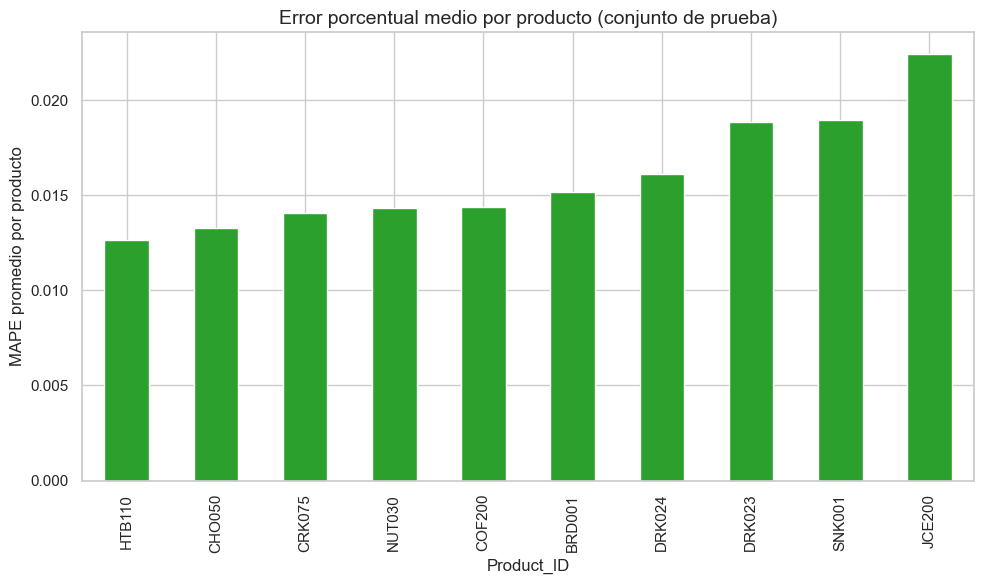

In [9]:

results_df['APE'] = (results_df['Quantity_Consumed'] - results_df['Predicted']).abs() / results_df['Quantity_Consumed']
product_perf = results_df.groupby('Product_ID')['APE'].mean().sort_values()

plt.figure(figsize=(10, 6))
product_perf.plot(kind='bar', color='#2ca02c')
plt.ylabel('MAPE promedio por producto')
plt.title('Error porcentual medio por producto (conjunto de prueba)')
plt.tight_layout()
plt.show()


In [10]:

product_monitor = (
    results_df.groupby('Product_ID')
    .agg(
        registros=('APE', 'size'),
        mape_medio=('APE', lambda x: np.mean(x) * 100),
        mape_mediana=('APE', lambda x: np.median(x) * 100),
        mape_p95=('APE', lambda x: np.quantile(x, 0.95) * 100),
        consumo_medio=('Quantity_Consumed', 'mean'),
    )
    .sort_values('mape_medio')
)

print('Resumen de monitoreo por producto (porcentajes en %):')
display(product_monitor.round({'mape_medio': 2, 'mape_mediana': 2, 'mape_p95': 2, 'consumo_medio': 1}))


Resumen de monitoreo por producto (porcentajes en %):


,registros,mape_medio,mape_mediana,mape_p95,consumo_medio
Product_ID,,,,,
HTB110,18,1.27,0.77,3.45,80.8
CHO050,15,1.33,0.82,4.74,69.3
CRK075,13,1.40,1.50,2.18,76.9
NUT030,15,1.43,1.10,3.24,73.1
COF200,18,1.44,0.83,3.65,78.2
BRD001,18,1.52,0.93,3.89,76.6
DRK024,17,1.61,1.54,3.78,100.6
DRK023,17,1.89,1.58,4.24,102.2
SNK001,14,1.89,1.69,4.06,80.9


## 9. Modelos especificos por Service_Type

In [11]:

service_models = {}
service_metrics = []

for service_type in sorted(X['Service_Type'].unique()):
    mask = X['Service_Type'] == service_type
    subset_size = mask.sum()
    if subset_size < 60:
        print(f'Se omite {service_type} por datos insuficientes ({subset_size} filas).')
        continue

    X_service = X.loc[mask].copy()
    y_service = y.loc[mask].copy()
    groups_service = GROUPS.loc[mask]

    splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)
    train_idx, test_idx = next(splitter.split(X_service, y_service, groups=groups_service))

    X_train_s, X_test_s = X_service.iloc[train_idx], X_service.iloc[test_idx]
    y_train_s, y_test_s = y_service.iloc[train_idx], y_service.iloc[test_idx]
    train_groups_s = groups_service.iloc[train_idx]

    n_unique_groups = train_groups_s.nunique()
    n_splits = max(2, min(3, n_unique_groups))
    if n_unique_groups < 2:
        print(f'Se omite {service_type} por falta de variedad de vuelos ({n_unique_groups} grupos).')
        continue

    service_preprocessor = ColumnTransformer(
        transformers=[
            ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_features),
            ('numeric', 'passthrough', numeric_features),
        ]
    )

    service_regressor = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=400,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        min_child_weight=3,
        gamma=0,
        random_state=RANDOM_STATE,
        tree_method='hist'
    )

    service_pipeline = Pipeline(
        steps=[
            ('preprocessor', service_preprocessor),
            ('regressor', service_regressor)
        ]
    )

    service_search = RandomizedSearchCV(
        estimator=service_pipeline,
        param_distributions=param_distributions,
        n_iter=10,
        scoring='neg_mean_absolute_percentage_error',
        cv=GroupKFold(n_splits=n_splits),
        random_state=RANDOM_STATE,
        verbose=0,
        n_jobs=1
    )

    service_search.fit(X_train_s, y_train_s, groups=train_groups_s)
    best_service_pipeline = service_search.best_estimator_

    y_pred_train_s = best_service_pipeline.predict(X_train_s)
    y_pred_test_s = best_service_pipeline.predict(X_test_s)

    train_mape_s = mean_absolute_percentage_error(y_train_s, y_pred_train_s)
    test_mape_s = mean_absolute_percentage_error(y_test_s, y_pred_test_s)
    train_mae_s = mean_absolute_error(y_train_s, y_pred_train_s)
    test_mae_s = mean_absolute_error(y_test_s, y_pred_test_s)
    test_r2_s = r2_score(y_test_s, y_pred_test_s)

    metrics = {
        'Service_Type': service_type,
        'train_mape': train_mape_s * 100,
        'test_mape': test_mape_s * 100,
        'train_mae': train_mae_s,
        'test_mae': test_mae_s,
        'test_r2': test_r2_s,
        'train_rows': len(X_train_s),
        'test_rows': len(X_test_s),
    }
    service_metrics.append(metrics)

    service_models[service_type] = {
        'pipeline': best_service_pipeline,
        'best_params': service_search.best_params_,
        'train_mape': train_mape_s,
        'test_mape': test_mape_s,
        'train_mae': train_mae_s,
        'test_mae': test_mae_s,
        'test_r2': test_r2_s,
        'train_rows': len(X_train_s),
        'test_rows': len(X_test_s),
    }

if service_metrics:
    service_metrics_df = pd.DataFrame(service_metrics).set_index('Service_Type')
    display(service_metrics_df.round({'train_mape': 2, 'test_mape': 2, 'train_mae': 2, 'test_mae': 2, 'test_r2': 3}))
else:
    service_metrics_df = pd.DataFrame()


,train_mape,test_mape,train_mae,test_mae,test_r2,train_rows,test_rows
Service_Type,,,,,,,
Pick & Pack,0.33,1.94,0.31,2.47,0.992,376,91
Retail,0.30,1.53,0.19,0.86,0.998,261,64


## 10. Importancia de caracteristicas

In [12]:

regressor = best_pipeline.named_steps['regressor']
feature_names = best_pipeline.named_steps['preprocessor'].get_feature_names_out()
importances = pd.Series(regressor.feature_importances_, index=feature_names)

print('Top 15 importancias:')
importances.sort_values(ascending=False).head(15)


Top 15 importancias:


numeric__Standard_Specification_Qty      0.304503
numeric__weight_per_spec                 0.250271
numeric__weight_per_passenger            0.119102
categorical__Flight_Type_medium-haul     0.105798
numeric__consumption_per_passenger       0.076148
categorical__Flight_Type_long-haul       0.061671
categorical__Service_Type_Retail         0.023877
categorical__Flight_Type_short-haul      0.016309
numeric__return_ratio                    0.014559
numeric__consumed_ratio                  0.008494
numeric__Passenger_Count                 0.007091
categorical__Origin_DOH                  0.003749
categorical__Service_Type_Pick & Pack    0.001873
categorical__Product_ID_DRK023           0.000516
numeric__month                           0.000490
dtype: float32

## 11. Guardado del modelo

In [13]:

output_path = Path('../backend/models/consumption_prediction_xgb.pkl')
output_path.parent.mkdir(parents=True, exist_ok=True)

artifact = {
    'model': best_pipeline,
    'features': FEATURES,
    'categorical_features': categorical_features,
    'numeric_features': numeric_features,
    'best_params': search.best_params_,
    'train_mape': train_mape,
    'test_mape': test_mape,
    'train_mae': train_mae,
    'test_mae': test_mae,
    'service_models': {
        service: {
            'model': info['pipeline'],
            'best_params': info['best_params'],
            'train_mape': info['train_mape'],
            'test_mape': info['test_mape'],
            'train_mae': info['train_mae'],
            'test_mae': info['test_mae'],
            'test_r2': info['test_r2'],
            'train_rows': info['train_rows'],
            'test_rows': info['test_rows'],
        }
        for service, info in service_models.items()
    },
    'service_metrics': service_metrics
}

joblib.dump(artifact, output_path)
print(f'Modelo guardado en {output_path.resolve()}')


Modelo guardado en C:\Users\Lenovo\Desktop\UdeCodes\backend\models\consumption_prediction_xgb.pkl
